In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
class Config:
    def __init__(self):
        self.ROOT_DATA_DIR = "FashionMNISTDir"
        self.EPOCH = 10
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.01
        self.IMAGE_SIZE = (28,28)
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"This notebook is using device: {self.DEVICE}")
        self.SEED = 2022
        
config = Config()

This notebook is using device: cuda


In [3]:
train_data = datasets.FashionMNIST(root = config.ROOT_DATA_DIR,
                                  train=True,download=True,transform = transforms.ToTensor(),
                                  )
test_data = datasets.FashionMNIST(root = config.ROOT_DATA_DIR,
                                  train=False,download=True,transform = transforms.ToTensor(),
                                  )

In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [6]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
given_label_map = train_data.class_to_idx
given_label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
label_map = {val:key for key,val in given_label_map.items()}
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Visualize one of the samples

In [10]:
def view_sample_image(data,idx,label_map):
    plt.imshow(train_data.data[idx],cmap='gray')
    plt.title(f"data label1: {label_map[train_data.targets[idx].item()]}")
    plt.axis("off")

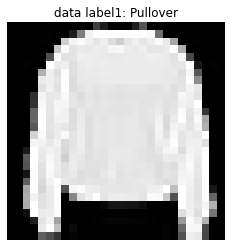

In [11]:
view_sample_image(train_data,7,label_map)

### Create the Data Loader

In [12]:
train_data_loader = DataLoader(dataset = train_data,batch_size=config.BATCH_SIZE,shuffle=True)

test_data_loader = DataLoader(dataset=train_data,
                               batch_size=config.BATCH_SIZE,
                               shuffle=False)


In [13]:
for image,label in train_data_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [14]:
image[0].shape

torch.Size([1, 28, 28])

In [15]:
image[0].squeeze().shape

torch.Size([28, 28])

In [16]:
image[0].squeeze().numpy()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.3137255 , 0.5921569 , 0.40784314, 0.43137255,
        0.44313726, 0.53333336, 0.35686275, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.6784314 , 0.8392157 , 0.7921569 , 0.84705883,
        0.81960785, 0.8509804 , 0.73333335, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.17254902, 0.7294118 , 0.74509805, 0.7372549 , 0.827451  ,
        0.7607843 , 0.7568

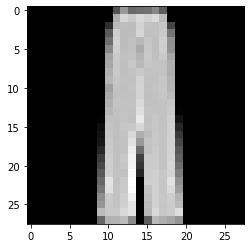

In [17]:
plt.imshow(image[0].squeeze(),cmap='gray')

In [18]:
image[0].shape, image[0].squeeze().shape, image[0].unsqueeze(dim=1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [19]:
class CNN(nn.Module):
    def __init__(self,in_,out_):
        super(CNN,self).__init__()
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels = in_,out_channels = 8,kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4,out_features=128)
        self.FC_02 = nn.Linear(in_features=128,out_features=64)
        self.FC_03 = nn.Linear(in_features=64,out_features=out_)

    def forward(self,x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = F.relu(self.FC_01(x))
        x = F.relu(self.FC_02(x))
        x = F.relu(self.FC_03(x))
        return x

In [20]:
model = CNN(1,10)

print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [21]:
next(model.parameters()).is_cuda

False

In [22]:
model.to(config.DEVICE)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [23]:
next(model.parameters()).is_cuda

True

### Count the number of trianable parameters

In [24]:
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non_trainable": 0}
    for name, parameters in model.named_parameters():
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] += param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total parameters: {total}")
    return df


count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


### Training Loop

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = config.LEARNING_RATE)

In [26]:
for epoch in range(config.EPOCH):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images,labels in tqdm_epoch:
            tqdm_epoch.set_description(f"EPOCH {epoch+1}/{config.EPOCH}")

            #put the images on device
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)

            #forward pass
            outputs = model(images)
            loss = criterion(outputs,labels) #passing the pred and actual values

            #backward prop
            optimizer.zero_grad() # zero past gradients
            loss.backward() # calculate gradients
            optimizer.step() # weights updated


            tqdm_epoch.set_postfix(loss = loss.item())

EPOCH 10/10: 100%|██████████| 1875/1875 [00:31<00:00, 58.69it/s, loss=1.16] 


#### save the model

In [27]:
os.makedirs("model_dir",exist_ok=True)

In [28]:
model_file = os.path.join("model_dir","CNN_model.pth")
torch.save(model,model_file)

### Load the model

In [29]:
loaded_model = torch.load(model_file)

### Evaluate out model

In [30]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        images = data[0].to(config.DEVICE)
        labels = data[1].to(config.DEVICE)

        y_pred = model(images)

        pred = np.concatenate((pred,torch.argmax(y_pred,dim=1).cpu().numpy()))
        target = np.concatenate((target,labels.cpu().numpy()))

In [33]:
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

<AxesSubplot:>

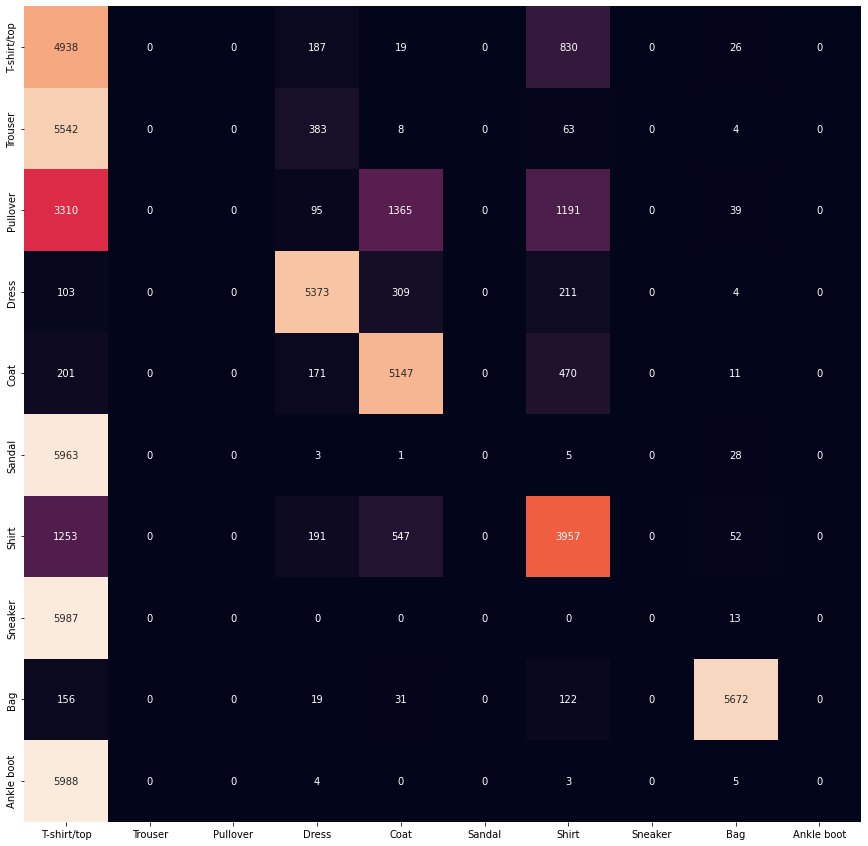

In [35]:
cm = confusion_matrix(target,pred)
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,fmt="d",cbar=False,xticklabels=label_map.values(),yticklabels=label_map.values())

### Prediction on our model

In [36]:
data = next(iter(test_data_loader))
data

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [37]:
len(data)

2

In [38]:
images,labels = data

In [39]:
images.shape

torch.Size([32, 1, 28, 28])

In [40]:
idx = 2
img = images[idx]
img.shape

torch.Size([1, 28, 28])

In [44]:
label = labels[idx]
label_map[label.item()]

'T-shirt/top'

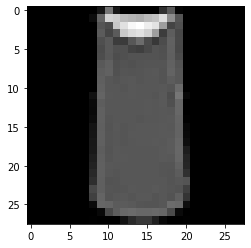

In [41]:
plt.imshow(img.squeeze(),cmap='gray')

In [46]:
img.unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [49]:
logit = model(img.unsqueeze(dim=0).to(config.DEVICE))
logit

tensor([[2.2089, 0.0000, 0.0000, 2.7886, 0.0000, 0.0000, 2.9118, 0.0000, 0.0000,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)

In [52]:
pred_prob = F.softmax(logit,dim=1)
pred_prob

tensor([[0.1794, 0.0197, 0.0197, 0.3203, 0.0197, 0.0197, 0.3623, 0.0197, 0.0197,
         0.0197]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [51]:
sum([0.1794, 0.0197, 0.0197, 0.3203, 0.0197, 0.0197, 0.3623, 0.0197, 0.0197,
         0.0197])

0.9999000000000002

In [53]:
argmax = torch.argmax(pred_prob).item()
argmax

6

In [54]:
label_map[argmax]

'Shirt'

In [58]:
def predict(data,model,label_map,device,idx=0):
    images,data = data
    img = images[idx]
    label = labels[idx]

    plt.imshow(img.squeeze(),cmap='gray')
    
    logit = model(img.unsqueeze(dim=0).to(config.DEVICE))

    pred_prob = F.softmax(logit,dim=1)
    argmax = torch.argmax(pred_prob).item()
    
    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]

    plt.title(f"actual: {actual_label}  |   predicted: {predicted_label}")
    plt.axis("off")

    return predicted_label,actual_label

('Shirt', 'T-shirt/top')

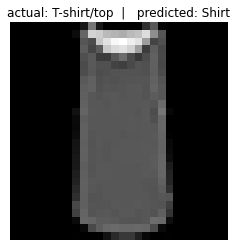

In [59]:
predict(data,model,label_map,device = config.DEVICE,idx =2)